# Classical geostatistics (geosclassic wrapper) - indicator variables (2D)

Estimation and simulation for a categorical variable, based on simple and ordinary kriging.
- estimation: estimate probabilities for each category
    - hard data only
    - search ellipsoid or unique neighborhood
- simulation: sequential indicator simulation (SIS) based on simple and ordinary kriging
    - hard data
    - search ellipsoid only

The covariance model can be
- stationary, *i.e.* any parameter (weight (or sill), ranges, orientation angle, etc.) is constant
- non-stationary, *i.e.* with some parameter (weight (or sill), ranges, orientation angle, etc.) depending on the location in the grid. *Note:* with a non-stationary covariance model
    - some functionalities such as getting the sill, range, or plotting the model are not available
    - a unique neighborhood can not be used for estimation

Simple kriging allows to specify the probability of each category, stationary (global) or non-stationary (local). By default the probabilities are set to the proportion of each category in the hard data values (stationary) or a uniform distribution if no hard data is present.

For ordinary kriging: the specified probabilities are used when estimation or simulation is done in a grid cell without any neighbor.

**Remark:** examples in 2D are proposed here.

## Import what is required

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

# import from package 'geone'
import geone.covModel as gcm
import geone.geosclassicinterface as gci
import geone.img as img
import geone.imgplot as imgplt
import geone.customcolors as ccol

### Remark
The matplotlib figures can be visualized in *interactive* mode:
- `%matplotlib notebook`: enable interactive mode
- `%matplotlib inline`: disable interactive mode

## Define the category values
A list of category values (facies) must be defined. Let `ncategory` be the length of this list, *i.e.* the number of categories.
- if `ncategory == 1`: the unique category value given must not be equal to 0; this is used for a binary case with values ("unique category value", 0), where 0 indicates the absence of the considered medium; conditioning data values should be "unique category value" or 0
- if `ncategory >= 2`: this is used for a multi-category case with given values (distinct); conditioning data values should be in the list of given values

In [2]:
category_values = [1., 2., 3.]
ncategory = len(category_values)

Set color for each category, and color maps for proportions (for further plots).

In [3]:
categCol = ['lightblue', 'orange', 'darkgreen']
cmap_categ = [ccol.custom_cmap(['white', c]) for c in categCol]

## Define the covariance model(s)
A covariance model is required for each category. If only one is defined, it is used for every category (it is ''recycled'').

Here in 2D, we define covariance model(s) in 2D: class `covModel2D`.

(See jupyter notebooks `ex_geosclassic_[123]d*.ipynb` for details.)

In [4]:
cov_model = gcm.CovModel2D(elem=[
    ('exponential', {'w':9., 'r':[150, 40]}), # elementary contribution
    ], alpha=-30, name='model-2D example')

## Launching simulation and estimation
The following functions are used:
- `gci.simulateIndicator<n>D` for simulation \<n\>D (sequential indicator simulation, SIS),
- `gci.estimateIndicator<n>D` for estimation \<n\>D (estimate probabilities),

where `n` is the space dimension (`1`, `2`, or `3`).

These functions launch a C program running in parallel (based on *OpenMP*). The number of threads used can be specified by the optional parameter (keyword argument) `nthreads`. Specifying for this parameter a number `-n`, negative or zero, means that the total number of cpus of the system (retrieved by `os.cpu_count()`) except `n` (but at least one) will be used. By default: `nthreads=-1`.

The first argument is the list of category of length `ncategory`, and the (list of) covariance model(s) is given as second argument.

The parameters (keyword arguments) `searchRadiusRelative`, `searchNeighborhoodSortMode`, and
`use_unique_neighborhood` are lists of length `ncategory`. As for the covariance model, if only one value (not a list is given), it is recycled. Each entry in the list is related to the corresponding category in the list of category values given in first argument. These parameters have a similar role as in the functions for simulation and estimation for a continuous values, *i.e.* `gci.simulate<n>D` and `gci.estimate<n>D` (see jupyter notebooks `ex_geosclassic_[123]d*.ipynb` for details.)

*Remark:* the keyword argument `verbose` allows to control what is displayed when or after running: `verbose=0` to display nothing, `verbose=1` to display warning(s) only, and `verbose=2` to display version of the code (and progress), and warning(s).

### Examples

Define the simulation grid.

In [5]:
nx, ny = 220, 230  # number of cells
dx, dy = 1.0, 1.0  # cell unit
ox, oy = 0.0, 0.0  # origin

dimension = (nx, ny)
spacing = (dx, dy)
origin = (ox, oy)

### Unconditional simulations (function `gci.simulateIndicator<n>D`)

In [6]:
nreal = 100
np.random.seed(321)
geosclassic_output = gci.simulateIndicator2D(
    category_values, cov_model, dimension, spacing, origin, method='simple_kriging', 
    searchRadiusRelative=1.0, nneighborMax=12, nreal=nreal)

Geos-Classic running... [VERSION 1.0 / BUILD NUMBER 20210714 / OpenMP 7 thread(s)]
Geos-Classic run complete


### Retrieve the results (and display)
The function `gci.simulateIndicator<n>D` returns the dictionary

`geosclassic_output = {'image':image, 'nwarning':nwarning, 'warnings':warnings}`

The realizations are stored in `geosclassic_output['image']`, an *image* (class `img.Img`) with as many variables as realizations (the i-th variable being the i-th realization).

The total number of warning(s) encountered during the run are stored in `geosclassic_output['nwarning']` (*int*), and all the distincts warning messages are stored in `geosclassic_output['warnings']` (it is a list, possibly empty).

In [7]:
# Total number of warning(s), and warning messages
geosclassic_output['nwarning'], geosclassic_output['warnings']

(0, [])

In [8]:
# Retrieve the realizations
simul = geosclassic_output['image']

# Compute proportion of each category (pixel-wise)
simul_prop = img.imageCategProp(simul, category_values)

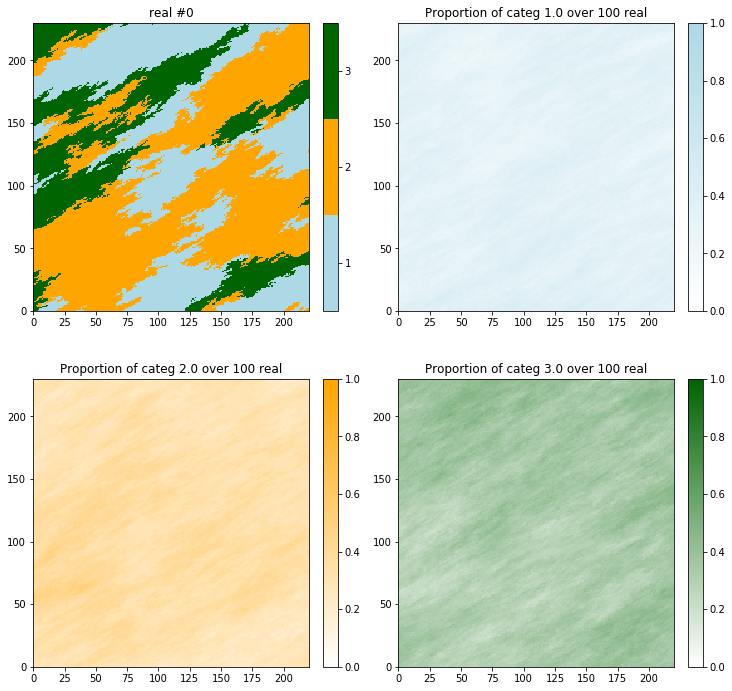

In [9]:
# Plot
plt.subplots(2, 2, figsize=(12,12))

plt.subplot(2,2,1)
imgplt.drawImage2D(simul, iv=0, categ=True, categCol=categCol, title='real #0')

for i in range(ncategory):
    plt.subplot(2,2,2+i)
    imgplt.drawImage2D(simul_prop, iv=i, vmin=0, vmax=1, cmap=cmap_categ[i], 
        title='Proportion of categ {} over {} real'.format(category_values[i], nreal))

plt.show()

### Conditional simulations (hard data) (function `gci.simulateIndicator<n>D`)
Define hard data. Note that the conditioning values will be attached to the grid cells containing the corresponding conditioning locations.

In [10]:
x = np.array([[ 10.,  20.], # 1st point
              [ 50.,  40.], # 2nd point
              [ 20., 150.], # 3rd point
              [200., 210.]]) # 4th point
v = [ 1., 2., 1., 3.] # values

Launch the simulations and plot.

In [11]:
nreal = 100
np.random.seed(321)
geosclassic_output = gci.simulateIndicator2D(
    category_values, cov_model, dimension, spacing, origin, 
    x=x, v=v, method='simple_kriging', 
    searchRadiusRelative=1.0, nneighborMax=12, nreal=nreal)

# Retrieve the realizations
simul = geosclassic_output['image']

# Compute proportion of each category (pixel-wise)
simul_prop = img.imageCategProp(simul, category_values)

Geos-Classic running... [VERSION 1.0 / BUILD NUMBER 20210714 / OpenMP 7 thread(s)]
Geos-Classic run complete


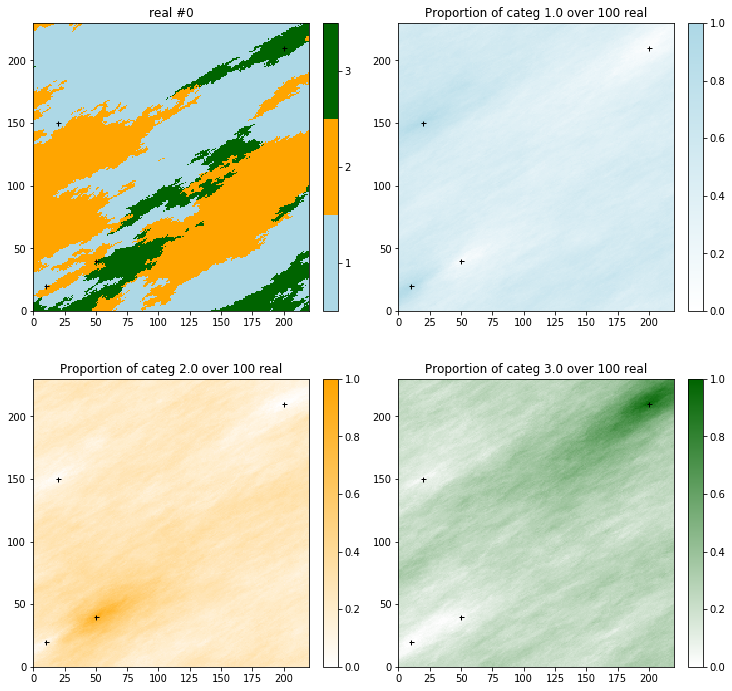

In [12]:
# Plot
plt.subplots(2, 2, figsize=(12,12))

plt.subplot(2,2,1)
imgplt.drawImage2D(simul, iv=0, categ=True, categCol=categCol, title='real #0')
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations

for i in range(ncategory):
    plt.subplot(2,2,2+i)
    imgplt.drawImage2D(simul_prop, iv=i, vmin=0, vmax=1, cmap=cmap_categ[i], 
        title='Proportion of categ {} over {} real'.format(category_values[i], nreal))
    plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations

plt.show()

### Estimation: estimate probabilities (by kriging) (function `gci.estimateIndicator<n>D`)

In [13]:
# Increase searchRadiusRelative to avoid "discontinuities"
# geosclassic_output = gci.estimateIndicator2D(
#     category_values, cov_model, dimension, spacing, origin, 
#     x=x, v=v, method='simple_kriging',
#     searchRadiusRelative=2.0)

# Or use a unique neighborhood
geosclassic_output = gci.estimateIndicator2D(
    category_values, cov_model, dimension, spacing, origin, 
    x=x, v=v, method='simple_kriging',
    use_unique_neighborhood=True)

Geos-Classic running... [VERSION 1.0 / BUILD NUMBER 20210714 / OpenMP 7 thread(s)]
Geos-Classic run complete


### Retrieve the results (and display)
The function `gci.estimateIndicator<n>D` returns the dictionary

`geosclassic_output = {'image':image, 'nwarning':nwarning, 'warnings':warnings}`

The estimate probabilities are stored in `geosclassic_output['image']`, an *image* (class `img.Img`) with `ncategory` variables: the i-th variable is the estimated probabilities for the i-th category.

As for the function `gci.simulateIndicator<n>D`, the warning(s) encountered during the run are stored in `geosclassic_output['nwarning']` (*int*), and all the distincts warning messages are stored in `geosclassic_output['warnings']` (it is a list, possibly empty).

In [14]:
# Retrieve the results of estimation
estim = geosclassic_output['image']

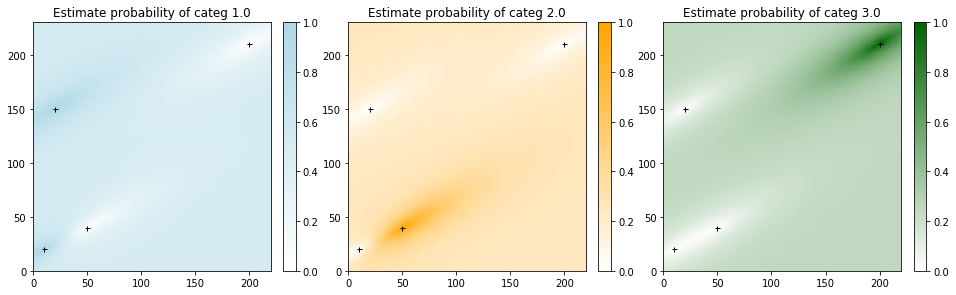

In [15]:
plt.subplots(1, 3, figsize=(16,12))

for i in range(ncategory):
    plt.subplot(1,3,1+i)
    imgplt.drawImage2D(estim, iv=i, vmin=0, vmax=1, cmap=cmap_categ[i], 
        title='Estimate probability of categ {}'.format(category_values[i]))
    plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations

plt.show()

### Simple and ordinary kriging

In [16]:
# simulation based on simple kriging
np.random.seed(444)
geosclassic_output = gci.simulateIndicator2D(
    category_values, cov_model, dimension, spacing, origin, 
    x=x, v=v, method='simple_kriging', nreal=1, verbose=1)
simul_simple_krig = geosclassic_output['image']

# estimation based on ordinary kriging
np.random.seed(444)
geosclassic_output = gci.estimateIndicator2D(
    category_values, cov_model, dimension, spacing, origin, 
    x=x, v=v, method='simple_kriging', use_unique_neighborhood=True)
estim_simple_krig = geosclassic_output['image']

# simulation based on ordinary kriging
geosclassic_output = gci.simulateIndicator2D(
    category_values, cov_model, dimension, spacing, origin, 
    x=x, v=v, method='ordinary_kriging', nreal=1, verbose=1)
simul_ordinary_krig = geosclassic_output['image']

# estimation based on ordinary kriging
geosclassic_output = gci.estimateIndicator2D(
    category_values, cov_model, dimension, spacing, origin, 
    x=x, v=v, method='ordinary_kriging', use_unique_neighborhood=True)
estim_ordinary_krig = geosclassic_output['image']

Geos-Classic running... [VERSION 1.0 / BUILD NUMBER 20210714 / OpenMP 7 thread(s)]
Geos-Classic run complete
Geos-Classic running... [VERSION 1.0 / BUILD NUMBER 20210714 / OpenMP 7 thread(s)]
Geos-Classic run complete


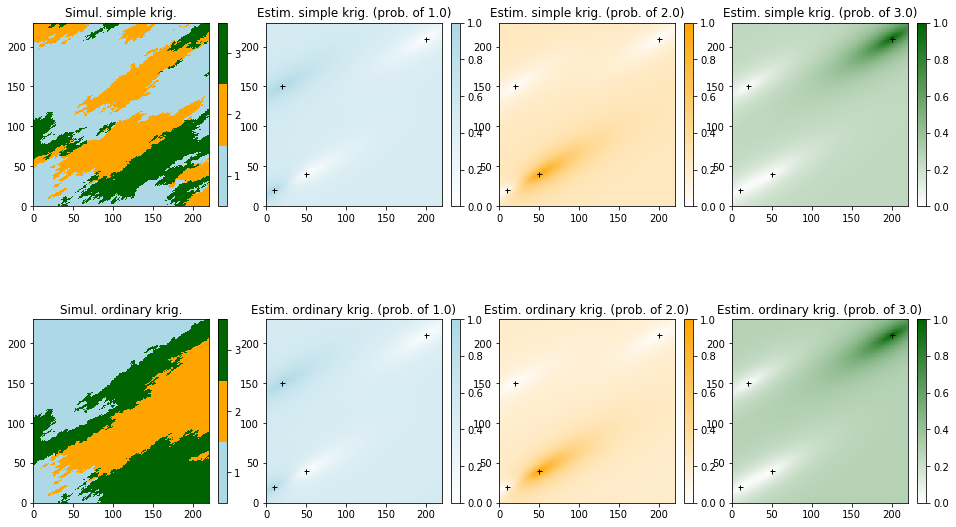

In [17]:
# plot
plt.subplots(2, 4, figsize=(16,10))

plt.subplot(2, 4, 1)
imgplt.drawImage2D(simul_simple_krig, iv=0, categ=True, categCol=categCol)
plt.title('Simul. simple krig.')

for i in range(ncategory):
    plt.subplot(2,4,2+i)
    imgplt.drawImage2D(estim_simple_krig, iv=i, vmin=0, vmax=1, cmap=cmap_categ[i])        
    plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations
    plt.title('Estim. simple krig. (prob. of {})'.format(category_values[i]))

plt.subplot(2, 4, 5)
imgplt.drawImage2D(simul_ordinary_krig, iv=0, categ=True, categCol=categCol)
plt.title('Simul. ordinary krig.')

for i in range(ncategory):
    plt.subplot(2,4,6+i)
    imgplt.drawImage2D(estim_ordinary_krig, iv=i, vmin=0, vmax=1, cmap=cmap_categ[i])        
    plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations
    plt.title('Estim. ordinary krig. (prob. of {})'.format(category_values[i]))

plt.show()

### Simulations with prescribed probabilities
Probabilities for the categories can be specified if simple kriging is used, they can be stationary (constant) or non-stationary. By default, the proportions of the categories in the conditioning data are used (or zero if no conditioning data) (constant).

With `ncategory>1`, the sum of probabilities (at each pixel if non-stationary) must sum to 1. If `ncategory==1`, only one value (per pixel if non-stationary) is given which must be between 0 and 1. 

### Simulations with constant probabilities

In [18]:
probability = [.1, .2, .7] # should sum to 1
# Simulation
nreal = 1
np.random.seed(321)
geosclassic_output = gci.simulateIndicator2D(
    category_values, cov_model, dimension, spacing, origin, 
    x=x, v=v, probability=probability, nreal=nreal)
simul = geosclassic_output['image']

# Estimation
geosclassic_output = gci.estimateIndicator2D(
    category_values, cov_model, dimension, spacing, origin, 
    x=x, v=v, probability=probability, use_unique_neighborhood=True)
estim = geosclassic_output['image']

Geos-Classic running... [VERSION 1.0 / BUILD NUMBER 20210714 / OpenMP 7 thread(s)]
Geos-Classic run complete
Geos-Classic running... [VERSION 1.0 / BUILD NUMBER 20210714 / OpenMP 7 thread(s)]
Geos-Classic run complete


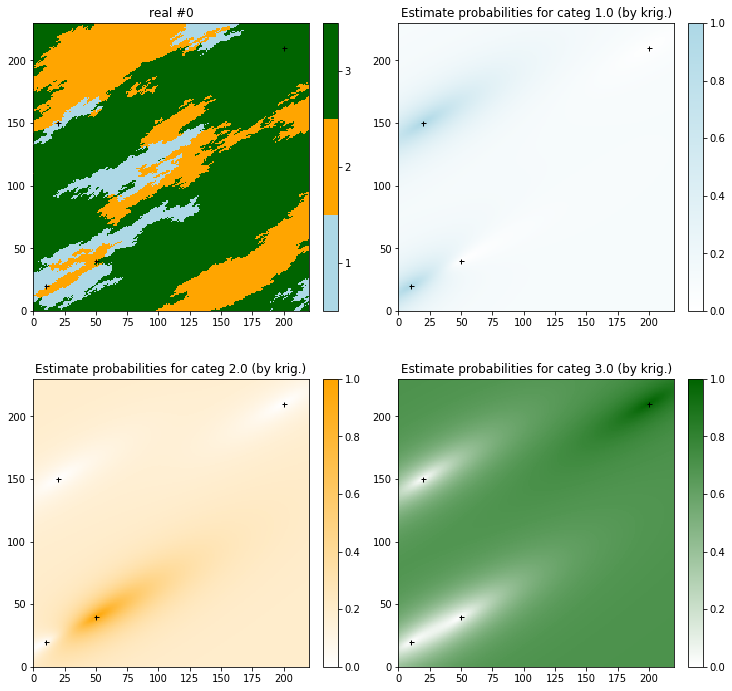

In [19]:
# Plot
plt.subplots(2, 2, figsize=(12,12))

plt.subplot(2,2,1)
imgplt.drawImage2D(simul, iv=0, categ=True, categCol=categCol, title='real #0')
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations

for i in range(ncategory):
    plt.subplot(2,2,2+i)
    imgplt.drawImage2D(estim, iv=i, vmin=0, vmax=1, cmap=cmap_categ[i], 
        title='Estimate probabilities for categ {} (by krig.)'.format(category_values[i]))
    plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations

plt.show()

### Simulations with non-stationary probabilities
Set varying probabilities over the simulation domain.

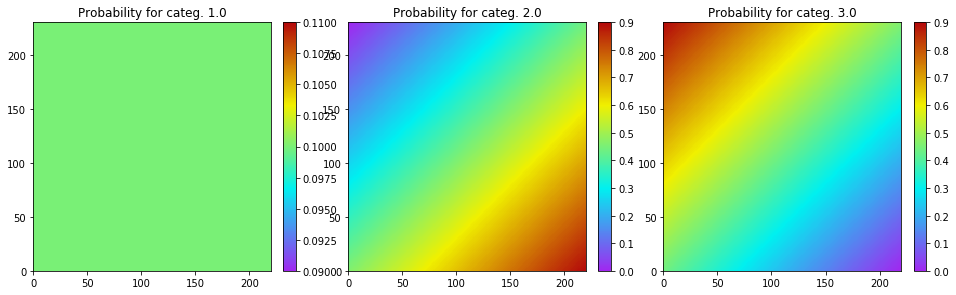

In [20]:
# Coordinates of the center of grid cells
xg = ox + dx*(0.5+np.arange(nx))
yg = oy + dy*(0.5+np.arange(ny))

# Create a meshgrid from the center of grid cells
xx, yy = np.meshgrid(xg, yg)

# Define probability maps for each category
c = 0.9
p1 = xx - yy     
p1 = c * (p1 - np.min(p1))/ (np.max(p1) - np.min(p1))
p2 = c - p1
p0 = (1. - c) * np.ones_like(p1) # 1.0 - p1 - p2 # constant map (0.1)

probability = np.array((p0, p1, p2))

# Fill image for display
im = img.Img(nx, ny, 1, dx, dy, 1., ox, oy, 0., nv=ncategory, val=probability)

# Display imposed mean and var
plt.subplots(1, 3, figsize=(16,12))

for i in range(ncategory):
    plt.subplot(1, 3, 1+i)
    imgplt.drawImage2D(im, iv=i, title = 'Probability for categ. {}'.format(category_values[i]))

plt.show()

In [21]:
nreal = 100
np.random.seed(321)
geosclassic_output = gci.simulateIndicator2D(
    category_values, cov_model, dimension, spacing, origin, 
    x=x, v=v, method='simple_kriging',
    probability=probability,
    searchRadiusRelative=1.0, nneighborMax=12, nreal=nreal)

# Retrieve the realizations
simul = geosclassic_output['image']

# Compute proportion of each category (pixel-wise)
simul_prop = img.imageCategProp(simul, category_values)

Geos-Classic running... [VERSION 1.0 / BUILD NUMBER 20210714 / OpenMP 7 thread(s)]
Geos-Classic run complete


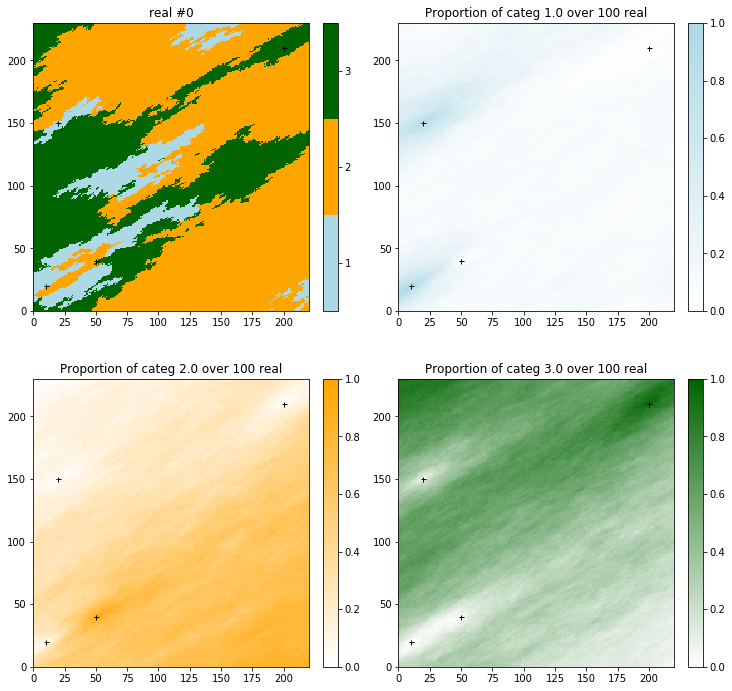

In [22]:
# Plot
plt.subplots(2, 2, figsize=(12,12))

plt.subplot(2,2,1)
imgplt.drawImage2D(simul, iv=0, categ=True, categCol=categCol, title='real #0')
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations

for i in range(ncategory):
    plt.subplot(2,2,2+i)
    imgplt.drawImage2D(simul_prop, iv=i, vmin=0, vmax=1, cmap=cmap_categ[i], 
        title='Proportion of categ {} over {} real'.format(category_values[i], nreal))
    plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations

plt.show()

## Example with non-stationary covariance model
As for simulation and estimation for a continuous variable, non-stationary covariance model can be defined. For details, see jupyter notebooks `ex_geosclassic_[123]d_non_stat_cov.ipynb`.

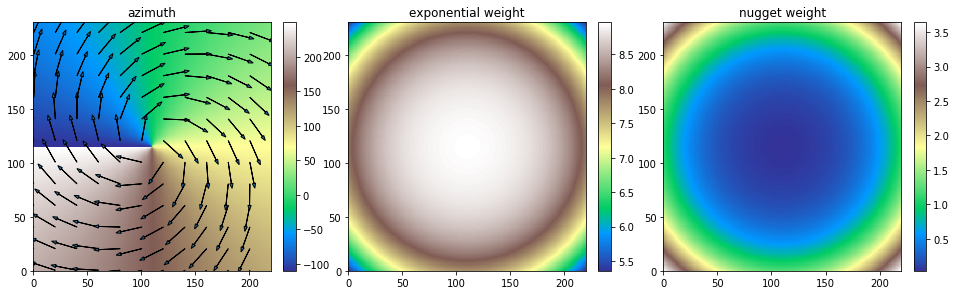

In [23]:
x_center = ox + 0.5*nx*dx
y_center = oy + 0.5*ny*dy 

xgrid = ox + (np.arange(nx)+0.5)*dx # x coordinate along the x-axis of the sim. grid
ygrid = oy + (np.arange(ny)+0.5)*dy # y coordinate along the y-axis of the sim. grid

xx, yy = np.meshgrid(xgrid, ygrid) # x, y coordinates of every sim. grid cell

# Define azimuth angle over the simulation grid
t = 180./np.pi
alpha = np.array(
    [90 - math.atan2(yi-y_center, xi-x_center)*t - 20
     for xi, yi in zip(xx.reshape(-1), yy.reshape(-1))]).reshape(xx.shape)

# Define weight for nugget and exponential model over the simulation grid
nug_w = 9. * 1. / (1. + np.exp(-(np.sqrt((xx-x_center)**2+(yy-y_center)**2)-170)/30))
exp_w = 9 - nug_w

im_alpha = img.Img(nx, ny, 1, dx, dy, 1., ox, oy, 0., nv=1, val=alpha)
im_exp_w = img.Img(nx, ny, 1, dx, dy, 1., ox, oy, 0., nv=1, val=exp_w)
im_nug_w = img.Img(nx, ny, 1, dx, dy, 1., ox, oy, 0., nv=1, val=nug_w)

# Plot
plt.subplots(1,3, figsize=(16,12))

plt.subplot(1,3,1)
imgplt.drawImage2D(im_alpha, cmap='terrain', title="azimuth")
len_arrow = 20.
for i in range(0, nx, 20):
    for j in range(0, ny, 20):
        u = xx[j, i]
        v = yy[j, i]
        a = -alpha[j,i]/t
        plt.arrow(u, v, len_arrow*np.cos(a), len_arrow*np.sin(a), head_width=3)

plt.subplot(1,3,2)
imgplt.drawImage2D(im_exp_w, cmap='terrain', title="exponential weight")

plt.subplot(1,3,3)
imgplt.drawImage2D(im_nug_w, cmap='terrain', title="nugget weight")

plt.show()

In [24]:
# Define the non-stationary covariance model 
cov_model = gcm.CovModel2D(elem=[
    ('exponential', {'w':exp_w, 'r':[120, 30]}), # elementary contribution
    ('nugget', {'w':nug_w}), # elementary contribution
    ], alpha=alpha, name='model-2D example')

In [25]:
# Conditioning data (as above)
x = np.array([[ 10.,  20.], # 1st point
              [ 50.,  40.], # 2nd point
              [ 20., 150.], # 3rd point
              [200., 210.]]) # 4th point
v = [ 1., 2., 1., 3.] # values

In [26]:
# Simulation
nreal = 100
np.random.seed(321)
geosclassic_output = gci.simulateIndicator2D(
    category_values, cov_model, dimension, spacing, origin, 
    x=x, v=v, method='simple_kriging', 
    searchRadiusRelative=1.0, nneighborMax=12, nreal=nreal)

Geos-Classic running... [VERSION 1.0 / BUILD NUMBER 20210714 / OpenMP 7 thread(s)]
Geos-Classic run complete


In [27]:
# Retrieve the realizations
simul = geosclassic_output['image']

# Compute proportion of each category (pixel-wise)
simul_prop = img.imageCategProp(simul, category_values)

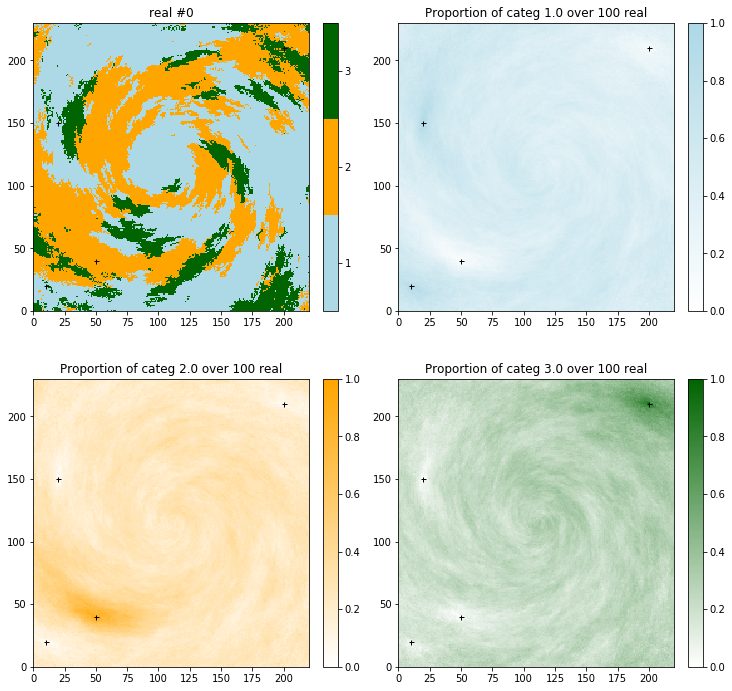

In [28]:
# Plot
plt.subplots(2, 2, figsize=(12,12))

plt.subplot(2,2,1)
imgplt.drawImage2D(simul, iv=0, categ=True, categCol=categCol, title='real #0')
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations

for i in range(ncategory):
    plt.subplot(2,2,2+i)
    imgplt.drawImage2D(simul_prop, iv=i, vmin=0, vmax=1, cmap=cmap_categ[i], 
        title='Proportion of categ {} over {} real'.format(category_values[i], nreal))
    plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations

plt.show()

#### Estimation: estimate probabilities
*Note:* unique search neighorhood can not be used with a non-stationary covariance model.

Extract random points from the first realization to set conditioning data.

In [29]:
im = img.Img(nx, ny, 1, dx, dy, 1., ox, oy, 0., nv=1, val=simul.val[0])
ps = img.extractRandomPointFromImage(im, 200, seed=444)
new_x = ps.val[0:2].T # location of conditioning data
new_v = ps.val[3]     # value at conditioning data

In [30]:
# Increase searchRadiusRelative to avoid "discontinuities"
geosclassic_output = gci.estimateIndicator2D(
    category_values, cov_model, dimension, spacing, origin, 
    x=new_x, v=new_v, method='simple_kriging',
    searchRadiusRelative=2.0)
estim = geosclassic_output['image']

Geos-Classic running... [VERSION 1.0 / BUILD NUMBER 20210714 / OpenMP 7 thread(s)]
Geos-Classic run complete


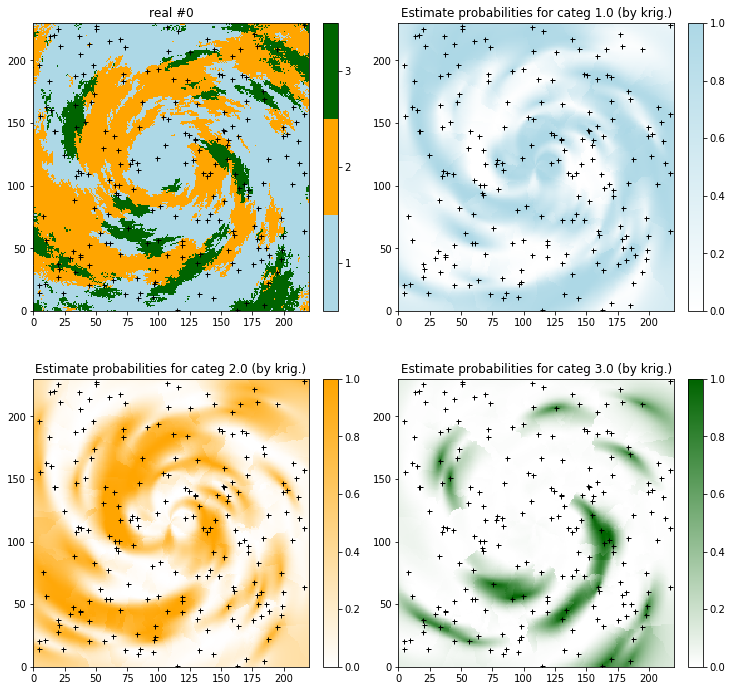

In [31]:
# Plot
plt.subplots(2, 2, figsize=(12,12))

plt.subplot(2,2,1)
imgplt.drawImage2D(simul, iv=0, categ=True, categCol=categCol, title='real #0')
plt.plot(new_x[:,0],new_x[:,1], '+', c='black', markersize=5) # add conditioning point locations

for i in range(ncategory):
    plt.subplot(2,2,2+i)
    imgplt.drawImage2D(estim, iv=i, vmin=0, vmax=1, cmap=cmap_categ[i], 
        title='Estimate probabilities for categ {} (by krig.)'.format(category_values[i]))
    plt.plot(new_x[:,0],new_x[:,1], '+', c='black', markersize=5) # add conditioning point locations

plt.show()